In [49]:
# numpy and pandas for data manipulation
import pandas as pd 
import numpy as np

# sklearn 
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, f1_score, recall_score, precision_score
from sklearn.metrics import precision_recall_curve, roc_curve, auc, fbeta_score, make_scorer
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

#gestion du desiquilibre de la classe TARGET
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN

#Boosting lightgbm
from lightgbm import LGBMClassifier

# File system manangement
import os

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

#regEX
import re
from collections import Counter

#serialisation du modele
import pickle

#mesure du temps
import timeit

#  UTILISATION d'une selection dans le jeu complet de données

selection faite dans kernel kaggle : https://www.kaggle.com/hikmetsezen/micro-model-174-features-0-8-auc-on-home-credit

In [4]:
df_feats = pd.read_csv('df_feats.csv')

In [5]:
df_feats

,Unnamed: 0,TARGET,SK_ID_CURR,POS_SK_DPD_DEF_SUM,CC_DRAWING_LIMIT_RATIO_MAX,INSTAL_PAYMENT_RATIO_MEAN,POS_REMAINING_INSTALMENTS,CC_LAST_AMT_BALANCE_MEAN,CC_PAYMENT_DIV_MIN_MIN,CC_LATE_PAYMENT_VAR,...,BURO_CREDIT_TYPE_Mortgage_MEAN,AMT_GOODS_PRICE,APPROVED_CNT_PAYMENT_MEAN,FLAG_DOCUMENT_7,FLAG_DOCUMENT_18,NONLIVINGAPARTMENTS_MEDI,ACTIVE_AMT_CREDIT_MAX_OVERDUE_MEAN,ORGANIZATION_TYPE_Construction,INSTAL_AMT_PAYMENT_MIN,BURO_AMT_CREDIT_SUM_DEBT_MEAN
0,0,1,100002,0.0,NaN,1.00000,6.0,NaN,NaN,NaN,...,0.0,351000.0,24.00,0,0,0.0000,40.5000,0,9251.775,49156.20
1,1,0,100003,0.0,NaN,1.00000,1.0,NaN,NaN,NaN,...,0.0,1129500.0,10.00,0,0,0.0039,0.0000,0,6662.970,0.00
2,2,0,100004,0.0,NaN,1.00000,0.0,NaN,NaN,NaN,...,0.0,135000.0,4.00,0,0,NaN,NaN,0,5357.250,0.00
3,3,0,100006,0.0,NaN,1.00000,3.0,0.0,NaN,0.0,...,NaN,297000.0,18.00,0,0,NaN,NaN,0,2482.920,NaN
4,4,0,100007,0.0,NaN,1.00000,14.0,NaN,NaN,NaN,...,0.0,513000.0,20.67,0,0,NaN,NaN,0,0.180,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307501,307501,0,456251,0.0,NaN,1.00000,0.0,NaN,NaN,NaN,...,NaN,225000.0,8.00,0,0,0.0757,NaN,0,6605.910,NaN
307502,307502,0,456252,0.0,NaN,1.00000,0.0,NaN,NaN,NaN,...,NaN,225000.0,6.00,0,0,0.0000,NaN,0,10046.880,NaN
307503,307503,0,456253,5.0,NaN,1.00000,0.0,NaN,NaN,NaN,...,0.0,585000.0,5.00,0,0,0.0000,NaN,0,27.270,448958.25
307504,307504,1,456254,0.0,NaN,1.00000,12.0,NaN,NaN,NaN,...,0.0,319500.0,15.00,0,0,NaN,NaN,0,2296.440,0.00


In [6]:
df_feats.drop(columns='Unnamed: 0', inplace=True)
df_feats = df_feats.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

X_feats = df_feats.drop(columns='TARGET').copy()
y_feats = df_feats['TARGET'].copy()

## imputation valeurs simples

In [7]:
df_feats.replace([np.inf, -np.inf], np.nan, inplace=True)
col_num = list(df_feats.select_dtypes('float64').columns)
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean', copy=False)
df_feats[col_num] = imp_mean.fit_transform(df_feats[col_num])

In [8]:
col_num = list(df_feats.select_dtypes('int64').columns)
imp_meanN = SimpleImputer(missing_values=np.nan, strategy='mean', copy=False)
df_feats[col_num] = imp_meanN.fit_transform(df_feats[col_num])

In [9]:
X_feats_impute = df_feats.drop(columns='TARGET').copy()
y_feats_impute = df_feats['TARGET'].copy()

### separation train/test set

In [10]:
X_train, X_val, y_train, y_val = train_test_split(X_feats_impute, y_feats_impute, test_size=0.2, stratify=y_feats_impute, random_state=1944)
X_feats_train, X_feats_val, y_feats_train, y_feats_val = train_test_split(X_feats, y_feats, test_size=0.2, stratify=y_feats, random_state=1944)

In [11]:
print('y_train', Counter(y_train))
print('y_val', Counter(y_val))

y_train Counter({0.0: 226145, 1.0: 19859})
y_val Counter({0.0: 56537, 1.0: 4965})


# definition metrique et fonction evaluation

In [12]:
# il est important de faire ressortir les FNs car perte de capital
# trouver les TP est interessant aussi car interet
# les FP sont moins risqués car perte d'interet seulement

def custom_metric(y, y_pred):
    TP = np.sum( (y==1) & (y_pred==1) )
    FP = np.sum( (y==0) & (y_pred==1) )
    TN = np.sum( (y==0) & (y_pred==0) )
    FN = np.sum( (y==1) & (y_pred==0) )
# Fowlkes–Mallows index 
# https://en.wikipedia.org/wiki/Confusion_matrix
# https://en.wikipedia.org/wiki/Fowlkes%E2%80%93Mallows_index
# Positive predictive value PPV
    PPV = TP / (TP + FP)
# Positive predictive value TPR
    TPR = TP / (TP + FN)
    FMI = np.sqrt( PPV * TPR )
    return FMI

def custom_metric_f2(y, y_pred):
    """
        https://machinelearningmastery.com/fbeta-measure-for-machine-learning/
        F2-Measure
            The F2-measure is an example of the Fbeta-measure with a beta value of 2.0.

            It has the effect of lowering the importance of precision and increase the importance of recall.

            If maximizing precision minimizes false positives, and maximizing recall minimizes false negatives, then the F2-measure puts more attention on minimizing false negatives than minimizing false positives.

    """
    return fbeta_score(y, y_pred,2)

custom_scorer = make_scorer(custom_metric, greater_is_better=True )
custom_scorer_f2 = make_scorer(custom_metric_f2, greater_is_better=True )

In [13]:

def model_eval_score(model, Xval, yval):
    yval_pred = model.predict(Xval)
    conf_mat = confusion_matrix(yval, yval_pred)
    print(conf_mat)
    print(f'Accuracy score    : {accuracy_score(yval, yval_pred):.3}')
    print(f'precision score   : {precision_score(yval, yval_pred):.3}')
    print(f'recall score      : {recall_score(yval, yval_pred):.3}')
    print(f'F1 score          : {f1_score(yval, yval_pred):.3}')
    print(f'F2 score          : {fbeta_score(yval, yval_pred,2):.3}')
    print(f'ROCAUC score      : {roc_auc_score(yval, yval_pred):.3}')
    print(f'custom metric FMI : {custom_metric(yval, yval_pred):.3}')
    print()

def model_eval(model, Xval, yval):
    model_eval_score(model, Xval, yval)
    
    yval_proba = model.predict_proba(Xval)[:, 1]
    fpr, tpr, thresholds = roc_curve(yval, yval_proba)
    roc_auc = auc(fpr, tpr)

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()


## comparaison hasard Dummy

[[51928  4609]
 [ 4610   355]]
Accuracy score    : 0.85
precision score   : 0.0715
recall score      : 0.0715
F1 score          : 0.0715
F2 score          : 0.0715
ROCAUC score      : 0.495
custom metric FMI : 0.0715



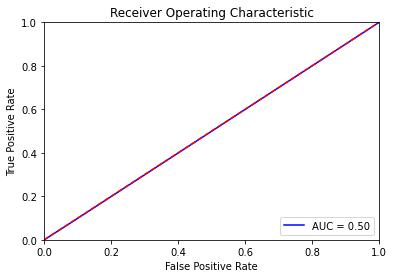

In [14]:

dummyCls = DummyClassifier(strategy='stratified')
dummyCls.fit(X_train, y_train)

model_eval(dummyCls, X_val, y_val)

## Logistic regression

[[56528     9]
 [ 4965     0]]
Accuracy score    : 0.919
precision score   : 0.0
recall score      : 0.0
F1 score          : 0.0
F2 score          : 0.0
ROCAUC score      : 0.5
custom metric FMI : 0.0



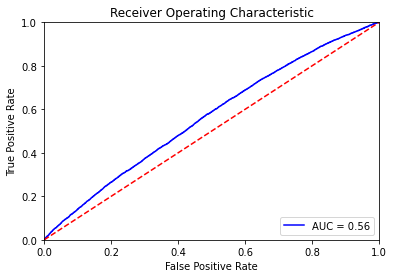

In [15]:

logis = LogisticRegression(solver='liblinear')
logis.fit(X_train, y_train)

model_eval(logis, X_val, y_val)

# gestion desequilibre
https://www.analyticsvidhya.com/blog/2020/07/10-techniques-to-deal-with-class-imbalance-in-machine-learning/

### gestion desequilibre
essai sous echantillonage

In [16]:

sample = RandomUnderSampler(random_state=1944)

# fit and apply the transform
X_under, y_under = sample.fit_resample(X_train, y_train)

print(Counter(y_train))
print(Counter(y_under))


Counter({0.0: 226145, 1.0: 19859})
Counter({0.0: 19859, 1.0: 19859})


[[32362 24175]
 [ 1882  3083]]
Accuracy score    : 0.576
precision score   : 0.113
recall score      : 0.621
F1 score          : 0.191
F2 score          : 0.327
ROCAUC score      : 0.597
custom metric FMI : 0.265



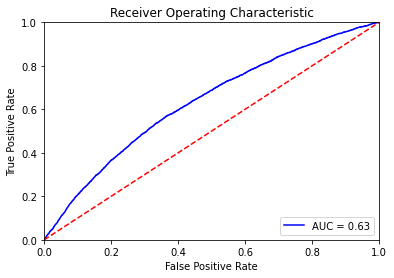

In [17]:
logis_under = LogisticRegression(solver='liblinear')
logis_under.fit(X_under, y_under)

model_eval(logis_under, X_val, y_val)

In [24]:
sample_undermiss = NearMiss()

# fit and apply the transform
X_undermis, y_undermiss = sample_undermiss.fit_resample(X_train, y_train)

print(Counter(y_train))
print(Counter(y_undermiss))


Counter({0.0: 226145, 1.0: 19859})
Counter({0.0: 19859, 1.0: 19859})


[[17990 38547]
 [ 1589  3376]]
Accuracy score    : 0.347
precision score   : 0.0805
recall score      : 0.68
F1 score          : 0.144
F2 score          : 0.273
ROCAUC score      : 0.499
custom metric FMI : 0.234



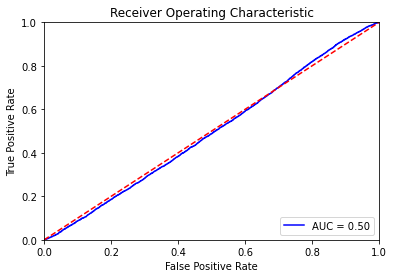

In [49]:
logis_undermiss = LogisticRegression(solver='liblinear')
logis_undermiss.fit(X_undermis, y_undermiss)

model_eval(logis_undermiss, X_val, y_val)

### gestion desequilibre
essai surechantillonage

In [50]:

sample = SMOTE(sampling_strategy=0.5, random_state=1944)

# fit and apply the transform
X_over, y_over = sample.fit_resample(X_train, y_train)

print(Counter(y_train))
print(Counter(y_over))


Counter({0.0: 226145, 1.0: 19859})
Counter({0.0: 226145, 1.0: 113072})


[[56240   297]
 [ 4890    75]]
Accuracy score    : 0.916
precision score   : 0.202
recall score      : 0.0151
F1 score          : 0.0281
F2 score          : 0.0185
ROCAUC score      : 0.505
custom metric FMI : 0.0552



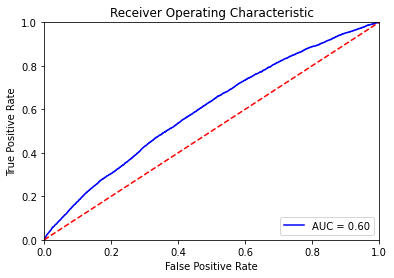

In [51]:
logis_over = LogisticRegression(solver='liblinear')
logis_over.fit(X_over, y_over)

model_eval(logis_over, X_val, y_val)

### gestion desequilibre
essai melange sous-echantillonage et surechantillonage

In [52]:

sample = SMOTEENN(random_state=1944)

# fit and apply the transform
X_smote, y_smote = sample.fit_resample(X_train, y_train)

print(Counter(y_train))
print(Counter(y_smote))


Counter({0.0: 226145, 1.0: 19859})
Counter({1.0: 217036, 0.0: 133326})


[[10206 46331]
 [  496  4469]]
Accuracy score    : 0.239
precision score   : 0.088
recall score      : 0.9
F1 score          : 0.16
F2 score          : 0.316
ROCAUC score      : 0.54
custom metric FMI : 0.281



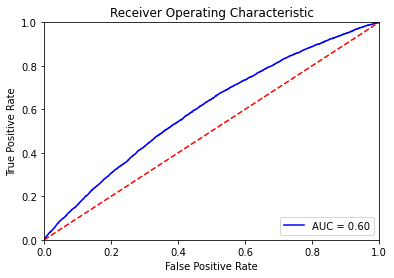

In [53]:
logis_smoteenn = LogisticRegression(solver='liblinear')
logis_smoteenn.fit(X_smote, y_smote)

model_eval(logis_smoteenn, X_val, y_val)

### recapitulatif desequilibre

In [54]:
model_eval_score(logis_under, X_val, y_val)

[[32362 24175]
 [ 1882  3083]]
Accuracy score    : 0.576
precision score   : 0.113
recall score      : 0.621
F1 score          : 0.191
F2 score          : 0.327
ROCAUC score      : 0.597
custom metric FMI : 0.265



In [55]:
model_eval_score(logis_undermiss, X_val, y_val)

[[17990 38547]
 [ 1589  3376]]
Accuracy score    : 0.347
precision score   : 0.0805
recall score      : 0.68
F1 score          : 0.144
F2 score          : 0.273
ROCAUC score      : 0.499
custom metric FMI : 0.234



In [56]:
model_eval_score(logis_over, X_val, y_val)

[[56240   297]
 [ 4890    75]]
Accuracy score    : 0.916
precision score   : 0.202
recall score      : 0.0151
F1 score          : 0.0281
F2 score          : 0.0185
ROCAUC score      : 0.505
custom metric FMI : 0.0552



In [57]:
model_eval_score(logis_smoteenn, X_val, y_val)

[[10206 46331]
 [  496  4469]]
Accuracy score    : 0.239
precision score   : 0.088
recall score      : 0.9
F1 score          : 0.16
F2 score          : 0.316
ROCAUC score      : 0.54
custom metric FMI : 0.281



# Decision Tree

[[51737  4800]
 [ 4104   861]]
Accuracy score    : 0.855
precision score   : 0.152
recall score      : 0.173
F1 score          : 0.162
F2 score          : 0.169
ROCAUC score      : 0.544
custom metric FMI : 0.162



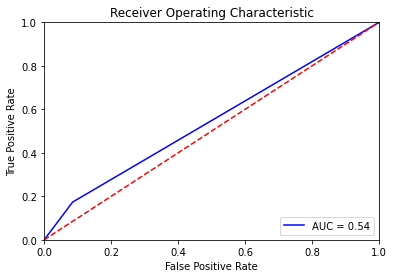

In [18]:

dectree = DecisionTreeClassifier(random_state=1944)
dectree.fit(X_train, y_train)
model_eval(dectree, X_val, y_val)

In [59]:

sample_under = RandomUnderSampler(random_state=1944)
sample_over = SMOTE(sampling_strategy=0.5, random_state=1944)
sample_undermiss = NearMiss()
sample = SMOTEENN(random_state=1944)


# fit and apply the transform
X_under, y_under = sample_under.fit_resample(X_train, y_train)
X_undermis, y_undermiss = sample_undermiss.fit_resample(X_train, y_train)
X_over, y_over = sample_over.fit_resample(X_train, y_train)
X_smote, y_smote = sample.fit_resample(X_train, y_train)

In [60]:
dectree_under = DecisionTreeClassifier(random_state=1944)
dectree_undermiss = DecisionTreeClassifier(random_state=1944)
dectree_over = DecisionTreeClassifier(random_state=1944)
dectree_smoteenn = DecisionTreeClassifier(random_state=1944)

dectree_under.fit(X_under, y_under)
dectree_undermiss.fit(X_undermis, y_undermiss)
dectree_over.fit(X_over, y_over)
dectree_smoteenn.fit(X_smote, y_smote)


DecisionTreeClassifier(random_state=1944)

[[33582 22955]
 [ 2015  2950]]
Accuracy score    : 0.594
precision score   : 0.114
recall score      : 0.594
F1 score          : 0.191
F2 score          : 0.322
ROCAUC score      : 0.594
custom metric FMI : 0.26



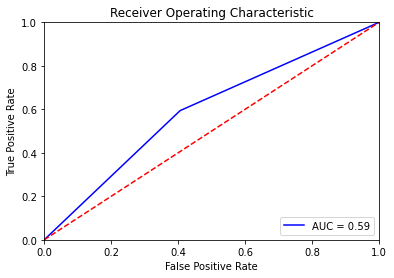

In [61]:
model_eval(dectree_under, X_val, y_val)

[[ 7809 48728]
 [  690  4275]]
Accuracy score    : 0.196
precision score   : 0.0807
recall score      : 0.861
F1 score          : 0.147
F2 score          : 0.293
ROCAUC score      : 0.5
custom metric FMI : 0.264



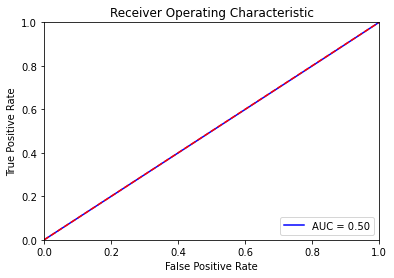

In [62]:
model_eval(dectree_undermiss, X_val, y_val)

[[50854  5683]
 [ 4052   913]]
Accuracy score    : 0.842
precision score   : 0.138
recall score      : 0.184
F1 score          : 0.158
F2 score          : 0.173
ROCAUC score      : 0.542
custom metric FMI : 0.16



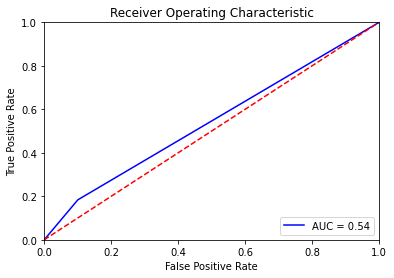

In [63]:
model_eval(dectree_over, X_val, y_val)

[[47914  8623]
 [ 3527  1438]]
Accuracy score    : 0.802
precision score   : 0.143
recall score      : 0.29
F1 score          : 0.191
F2 score          : 0.24
ROCAUC score      : 0.569
custom metric FMI : 0.203



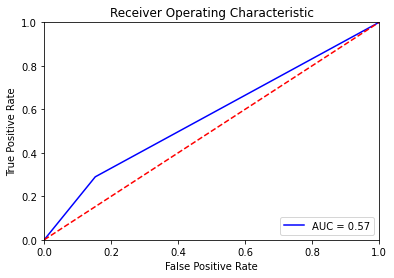

In [64]:
model_eval(dectree_smoteenn, X_val, y_val)

### recapitulatif desequilibre

In [76]:
model_eval_score(dectree_under, X_val, y_val)

[[33582 22955]
 [ 2015  2950]]
Accuracy score    : 0.594
precision score   : 0.114
recall score      : 0.594
F1 score          : 0.191
F2 score          : 0.322
ROCAUC score      : 0.594
custom metric FMI : 0.26



In [77]:
model_eval_score(dectree_undermiss, X_val, y_val)

[[ 7809 48728]
 [  690  4275]]
Accuracy score    : 0.196
precision score   : 0.0807
recall score      : 0.861
F1 score          : 0.147
F2 score          : 0.293
ROCAUC score      : 0.5
custom metric FMI : 0.264



In [78]:
model_eval_score(dectree_over, X_val, y_val)

[[50854  5683]
 [ 4052   913]]
Accuracy score    : 0.842
precision score   : 0.138
recall score      : 0.184
F1 score          : 0.158
F2 score          : 0.173
ROCAUC score      : 0.542
custom metric FMI : 0.16



In [79]:
model_eval_score(dectree_smoteenn, X_val, y_val)

[[47914  8623]
 [ 3527  1438]]
Accuracy score    : 0.802
precision score   : 0.143
recall score      : 0.29
F1 score          : 0.191
F2 score          : 0.24
ROCAUC score      : 0.569
custom metric FMI : 0.203



# RandomForest

[[56533     4]
 [ 4955    10]]
Accuracy score    : 0.919
precision score   : 0.714
recall score      : 0.00201
F1 score          : 0.00402
F2 score          : 0.00252
ROCAUC score      : 0.501
custom metric FMI : 0.0379



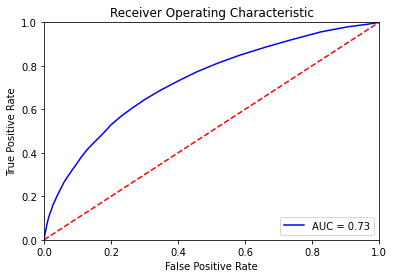

In [19]:
randomForest = RandomForestClassifier(random_state=1944)

randomForest.fit(X_train, y_train)
model_eval(randomForest, X_val, y_val)

[[56437   100]
 [ 4891    74]]
Accuracy score    : 0.919
precision score   : 0.425
recall score      : 0.0149
F1 score          : 0.0288
F2 score          : 0.0185
ROCAUC score      : 0.507
custom metric FMI : 0.0796



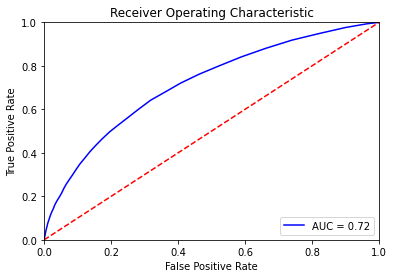

In [20]:
randomForest_weight = RandomForestClassifier(random_state=1944, class_weight={0:10,1:1})

randomForest_weight.fit(X_train, y_train)
model_eval(randomForest_weight, X_val, y_val)

In [23]:
randomForest_under = RandomForestClassifier(random_state=1944)
randomForest_under.fit(X_under, y_under)


RandomForestClassifier(random_state=1944)

In [25]:
randomForest_undermiss = RandomForestClassifier(random_state=1944)
randomForest_undermiss.fit(X_undermis, y_undermiss)


RandomForestClassifier(random_state=1944)

In [ ]:
randomForest_over = RandomForestClassifier(random_state=1944)
randomForest_over.fit(X_over, y_over)


In [ ]:
randomForest_smoteenn = RandomForestClassifier(random_state=1944)
randomForest_smoteenn.fit(X_smote, y_smote)


[[40137 16400]
 [ 1590  3375]]
Accuracy score    : 0.707
precision score   : 0.171
recall score      : 0.68
F1 score          : 0.273
F2 score          : 0.426
ROCAUC score      : 0.695
custom metric FMI : 0.341



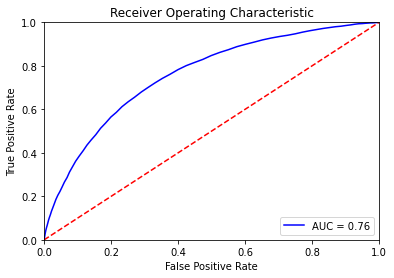

In [26]:
model_eval(randomForest_under, X_val, y_val)

[[ 7727 48810]
 [  766  4199]]
Accuracy score    : 0.194
precision score   : 0.0792
recall score      : 0.846
F1 score          : 0.145
F2 score          : 0.288
ROCAUC score      : 0.491
custom metric FMI : 0.259



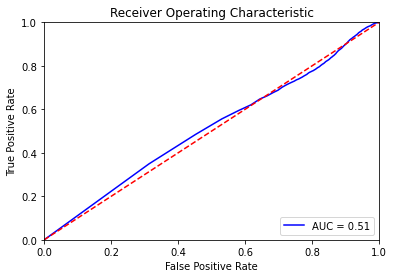

In [69]:
model_eval(randomForest_undermiss, X_val, y_val)

[[56523    14]
 [ 4945    20]]
Accuracy score    : 0.919
precision score   : 0.588
recall score      : 0.00403
F1 score          : 0.008
F2 score          : 0.00503
ROCAUC score      : 0.502
custom metric FMI : 0.0487



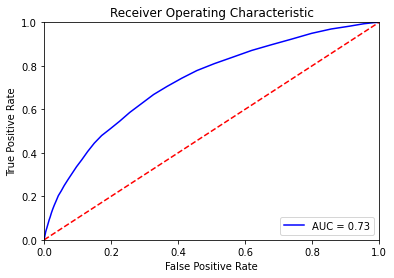

In [70]:
model_eval(randomForest_over, X_val, y_val)

[[55799   738]
 [ 4573   392]]
Accuracy score    : 0.914
precision score   : 0.347
recall score      : 0.079
F1 score          : 0.129
F2 score          : 0.0934
ROCAUC score      : 0.533
custom metric FMI : 0.165



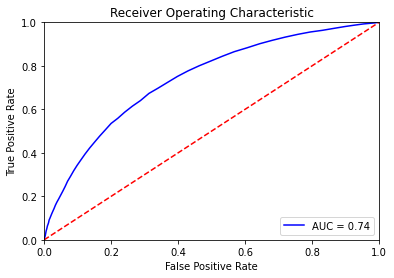

In [71]:
model_eval(randomForest_smoteenn, X_val, y_val)

### recapitulatif desequilibre

In [80]:
model_eval_score(randomForest_under, X_val, y_val)

[[40137 16400]
 [ 1590  3375]]
Accuracy score    : 0.707
precision score   : 0.171
recall score      : 0.68
F1 score          : 0.273
F2 score          : 0.426
ROCAUC score      : 0.695
custom metric FMI : 0.341



In [81]:
model_eval_score(randomForest_undermiss, X_val, y_val)

[[ 7727 48810]
 [  766  4199]]
Accuracy score    : 0.194
precision score   : 0.0792
recall score      : 0.846
F1 score          : 0.145
F2 score          : 0.288
ROCAUC score      : 0.491
custom metric FMI : 0.259



In [82]:
model_eval_score(randomForest_over, X_val, y_val)

[[56523    14]
 [ 4945    20]]
Accuracy score    : 0.919
precision score   : 0.588
recall score      : 0.00403
F1 score          : 0.008
F2 score          : 0.00503
ROCAUC score      : 0.502
custom metric FMI : 0.0487



In [83]:
model_eval_score(randomForest_smoteenn, X_val, y_val)

[[55799   738]
 [ 4573   392]]
Accuracy score    : 0.914
precision score   : 0.347
recall score      : 0.079
F1 score          : 0.129
F2 score          : 0.0934
ROCAUC score      : 0.533
custom metric FMI : 0.165



### a priori RandomForest avec strategie d'underFitting semble la plus prometteuse

In [84]:
model_eval_score(dummyCls, X_val, y_val)

[[51993  4544]
 [ 4579   386]]
Accuracy score    : 0.852
precision score   : 0.0783
recall score      : 0.0777
F1 score          : 0.078
F2 score          : 0.0779
ROCAUC score      : 0.499
custom metric FMI : 0.078



In [85]:
model_eval_score(logis_under, X_val, y_val)

[[32362 24175]
 [ 1882  3083]]
Accuracy score    : 0.576
precision score   : 0.113
recall score      : 0.621
F1 score          : 0.191
F2 score          : 0.327
ROCAUC score      : 0.597
custom metric FMI : 0.265



In [86]:
model_eval_score(dectree_under, X_val, y_val)

[[33582 22955]
 [ 2015  2950]]
Accuracy score    : 0.594
precision score   : 0.114
recall score      : 0.594
F1 score          : 0.191
F2 score          : 0.322
ROCAUC score      : 0.594
custom metric FMI : 0.26



In [87]:
model_eval_score(randomForest_under, X_val, y_val)

[[40137 16400]
 [ 1590  3375]]
Accuracy score    : 0.707
precision score   : 0.171
recall score      : 0.68
F1 score          : 0.273
F2 score          : 0.426
ROCAUC score      : 0.695
custom metric FMI : 0.341



In [88]:

random_grid_Forest = {'n_estimators': [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],
               'max_features':  ['auto', 'sqrt'],
               'max_depth': [int(x) for x in np.linspace(10, 110, num = 11)],
               'min_samples_split': [2, 5, 10],
               'min_samples_leaf': [1, 2, 4],
               'bootstrap': [True, False]}
print(random_grid_Forest)

# Random search of parameters, using 3 fold cross validation, 
rgf_random = RandomizedSearchCV(estimator = RandomForestClassifier(random_state=1944), param_distributions = random_grid_Forest, scoring=custom_scorer, n_iter = 40, cv = 3, verbose=2, n_jobs = -1)
# Fit the random search model
rgf_random.fit(X_under, y_under)

print(rgf_random.best_params_)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}
Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 21.2min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed: 79.5min finished


{'n_estimators': 1400, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 70, 'bootstrap': False}


[[40159 16378]
 [ 1517  3448]]
Accuracy score    : 0.709
precision score   : 0.174
recall score      : 0.694
F1 score          : 0.278
F2 score          : 0.434
ROCAUC score      : 0.702
custom metric FMI : 0.348



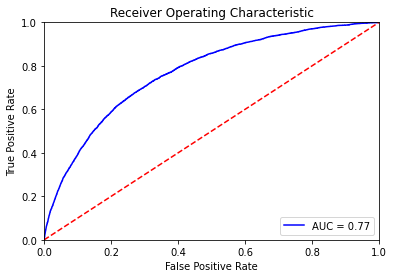

In [27]:
randomForest_under_random = RandomForestClassifier(random_state=1944, n_estimators = 1400, min_samples_split = 5,
                                                   min_samples_leaf = 2, max_features = 'auto', max_depth = 70, bootstrap = False)
randomForest_under_random.fit(X_under, y_under)
model_eval(randomForest_under_random, X_val, y_val)

In [28]:

random_grid_Forest_f2 = {'n_estimators': [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],
               'max_features':  ['auto', 'sqrt'],
               'max_depth': [int(x) for x in np.linspace(10, 110, num = 11)],
               'min_samples_split': [2, 5, 10],
               'min_samples_leaf': [1, 2, 4],
               'bootstrap': [True, False]}
print(random_grid_Forest_f2)

# Random search of parameters, using 3 fold cross validation, 
rgf_random_f2 = RandomizedSearchCV(estimator = RandomForestClassifier(random_state=1944), param_distributions = random_grid_Forest_f2, scoring=custom_scorer_f2, n_iter = 40, cv = 3, verbose=2, n_jobs = -1)
# Fit the random search model
rgf_random_f2.fit(X_under, y_under)

print(rgf_random_f2.best_params_)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}
Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 30.3min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed: 86.9min finished


{'n_estimators': 1800, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 30, 'bootstrap': False}


[[40080 16457]
 [ 1495  3470]]
Accuracy score    : 0.708
precision score   : 0.174
recall score      : 0.699
F1 score          : 0.279
F2 score          : 0.436
ROCAUC score      : 0.704
custom metric FMI : 0.349



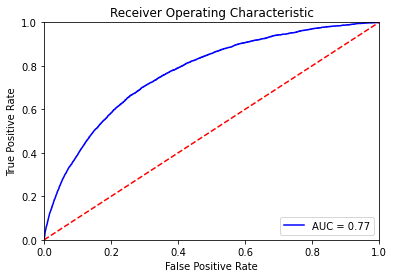

In [29]:
randomForest_under_random_f2 = RandomForestClassifier(random_state=1944, n_estimators = 1800, min_samples_split = 10,
                                                   min_samples_leaf = 4, max_features = 'auto', max_depth = 30, bootstrap = False)
randomForest_under_random_f2.fit(X_under, y_under)
model_eval(randomForest_under_random_f2, X_val, y_val)

In [90]:
model_eval_score(randomForest_under, X_val, y_val)

[[40137 16400]
 [ 1590  3375]]
Accuracy score    : 0.707
precision score   : 0.171
recall score      : 0.68
F1 score          : 0.273
F2 score          : 0.426
ROCAUC score      : 0.695
custom metric FMI : 0.341



In [30]:
model_eval_score(randomForest_under_random, X_val, y_val)

[[40159 16378]
 [ 1517  3448]]
Accuracy score    : 0.709
precision score   : 0.174
recall score      : 0.694
F1 score          : 0.278
F2 score          : 0.434
ROCAUC score      : 0.702
custom metric FMI : 0.348



In [31]:
model_eval_score(randomForest_under_random_f2, X_val, y_val)

[[40080 16457]
 [ 1495  3470]]
Accuracy score    : 0.708
precision score   : 0.174
recall score      : 0.699
F1 score          : 0.279
F2 score          : 0.436
ROCAUC score      : 0.704
custom metric FMI : 0.349



In [54]:
randomForest_under_random_f2 = RandomForestClassifier(random_state=1944, n_estimators = 1800, min_samples_split = 10,
                                                   min_samples_leaf = 4, max_features = 'auto', max_depth = 30, bootstrap = False)

start_time = timeit.default_timer()

# Create the parameter grid based on the results of random search 
params_grid = {
    'max_depth': [25 , 30, 35 ],
    'min_samples_leaf': [3,4,5],
    'min_samples_split': [8,10,12],
    'n_estimators': [1700, 1800, 1900]
}             
print( params_grid)

grid = GridSearchCV(RandomForestClassifier(random_state=1944, bootstrap = False, max_features = 'auto'),
                    param_grid = params_grid, scoring=custom_scorer_f2, cv=3, verbose=4, n_jobs = -1)
grid.fit(X_under, y_under)

elapsed = timeit.default_timer() - start_time
time = elapsed
print(f'resultat en {time:.2f}s')


{'max_depth': [25, 30, 35], 'min_samples_leaf': [3, 4, 5], 'min_samples_split': [8, 10, 12], 'n_estimators': [1700, 1800, 1900]}
Fitting 3 folds for each of 81 candidates, totalling 243 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed: 27.4min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed: 125.1min
[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed: 293.7min
[Parallel(n_jobs=-1)]: Done 243 out of 243 | elapsed: 333.4min finished


resultat en 20415.87s


In [55]:
grid.best_params_

{'max_depth': 25,
 'min_samples_leaf': 5,
 'min_samples_split': 12,
 'n_estimators': 1700}

[[40016 16521]
 [ 1492  3473]]
Accuracy score    : 0.707
precision score   : 0.174
recall score      : 0.699
F1 score          : 0.278
F2 score          : 0.436
ROCAUC score      : 0.704
custom metric FMI : 0.349



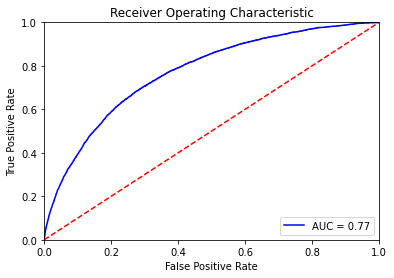

In [53]:
randomForest_under_gridCV_f2 = RandomForestClassifier(random_state=1944, bootstrap = False, max_features = 'auto',
                                                      n_estimators = 1700, min_samples_split = 12, min_samples_leaf = 5, max_depth = 25)
randomForest_under_gridCV_f2.fit(X_under, y_under)
model_eval(randomForest_under_gridCV_f2, X_val, y_val)

# BOOSTING

In [57]:
lgbmc10 = LGBMClassifier(is_unbalance=True)

lgbmc10.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], 
    eval_metric= 'auc', verbose= 200, early_stopping_rounds= 200)

Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.824881	training's binary_logloss: 0.525495	valid_1's auc: 0.780073	valid_1's binary_logloss: 0.537558


LGBMClassifier(is_unbalance=True)

[[41069 15468]
 [ 1528  3437]]
Accuracy score    : 0.724
precision score   : 0.182
recall score      : 0.692
F1 score          : 0.288
F2 score          : 0.443
ROCAUC score      : 0.709
custom metric FMI : 0.355



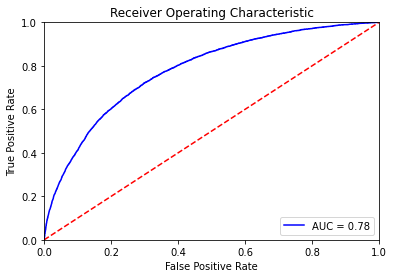

In [58]:
model_eval(lgbmc10, X_val, y_val)

In [59]:
lgbmc10_under = LGBMClassifier()

lgbmc10_under.fit(X_under, y_under, eval_set=[(X_under, y_under), (X_val, y_val)], 
    eval_metric= 'auc', verbose= 200, early_stopping_rounds= 200)

Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.846625	training's binary_logloss: 0.500014	valid_1's auc: 0.776679	valid_1's binary_logloss: 0.5655


LGBMClassifier()

[[40370 16167]
 [ 1488  3477]]
Accuracy score    : 0.713
precision score   : 0.177
recall score      : 0.7
F1 score          : 0.283
F2 score          : 0.44
ROCAUC score      : 0.707
custom metric FMI : 0.352



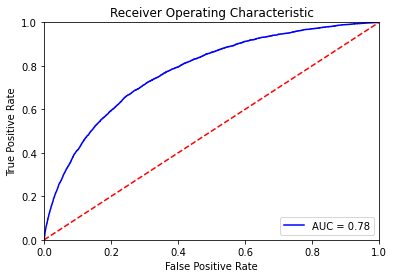

In [60]:
model_eval(lgbmc10_under, X_val, y_val)

In [61]:
def custom_lightgbm_valid(y_true, y_pred):
    TP = np.sum( (y_true==1) & (y_pred==1) )
    FP = np.sum( (y_true==0) & (y_pred==1) )
    TN = np.sum( (y_true==0) & (y_pred==0) )
    FN = np.sum( (y_true==1) & (y_pred==0) )
    precision  = TP / ( TP + FP )
    recall  = TP / ( TP + FN )
    f1_score = 2 * precision * recall / (precision + recall)
    f2_score = (5 * precision * recall) / (4 * precision + recall)
    return "F2 Score", f2_score, True
 
y_pred = lgbmc10.predict(X_val)
custom_lightgbm_valid(y_val, y_pred)

('F2 Score', 0.4433122662195279, True)

In [62]:
def custom_metric_light_gbm(y, y_pred):
    chaine, f2_score, dum = custom_lightgbm_valid(y, y_pred)
    return f2_score

y_pred = lgbmc10.predict(X_val)
print(custom_metric_light_gbm(y_val, y_pred))

custom_scorer_lgbm_f2 = make_scorer(custom_metric_light_gbm, greater_is_better=True )

0.4433122662195279


[[41069 15468]
 [ 1528  3437]]
Accuracy score    : 0.724
precision score   : 0.182
recall score      : 0.692
F1 score          : 0.288
F2 score          : 0.443
ROCAUC score      : 0.709
custom metric FMI : 0.355



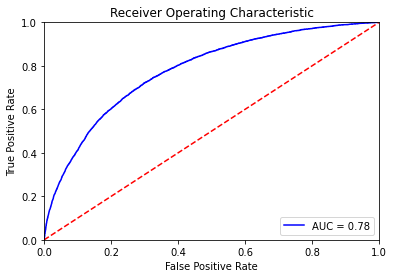

In [63]:
lgbmc10_custom = LGBMClassifier(is_unbalance=True)

lgbmc10_custom.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], 
    eval_metric= custom_lightgbm_valid, verbose= 200)

model_eval(lgbmc10_custom, X_val, y_val)

In [37]:
model_eval_score(lgbmc10, X_val, y_val)

[[41069 15468]
 [ 1528  3437]]
Accuracy score    : 0.724
precision score   : 0.182
recall score      : 0.692
F1 score          : 0.288
F2 score          : 0.443
ROCAUC score      : 0.709
custom metric FMI : 0.355



{'num_leaves': array([ 50, 100, 150, 200, 250, 300, 350, 400, 450]), 'min_child_samples': [20, 50, 150, 400], 'min_child_weight': [1e-05, 0.01, 0.1, 1, 10.0, 100.0, 1000.0], 'subsample': [0.1, 0.3, 0.6, 1.0], 'colsample_bytree': [0.8, 0.9, 1.0], 'reg_lambda': [0, 0.1, 1, 10, 100]}
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed: 16.0min
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed: 38.7min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 41.3min finished


{'subsample': 0.6, 'reg_lambda': 100, 'num_leaves': 50, 'min_child_weight': 1e-05, 'min_child_samples': 150, 'colsample_bytree': 0.9}
[[41247 15290]
 [ 1546  3419]]
Accuracy score    : 0.726
precision score   : 0.183
recall score      : 0.689
F1 score          : 0.289
F2 score          : 0.443
ROCAUC score      : 0.709
custom metric FMI : 0.355



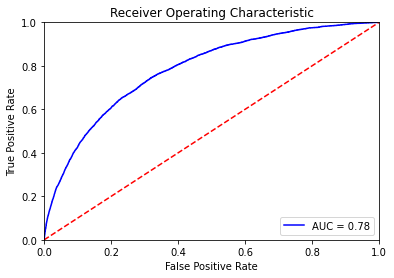

In [80]:
random_grid ={
            'num_leaves': np.arange(50,500,50),
            'min_child_samples': [20, 50, 150, 400], 
            'min_child_weight': [1e-5, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3],
            'subsample': [0.1, 0.3, 0.6, 1.0], 
            'colsample_bytree': [0.8, 0.9, 1.0],
            'reg_lambda': [0, 0.1, 1, 10, 100]}

print(random_grid)

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
lgbm_random = RandomizedSearchCV(estimator = LGBMClassifier(is_unbalance=True, objective = 'binary', metric = 'auc'), scoring=custom_scorer_lgbm_f2, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=3, n_jobs = -1)
# Fit the random search model
lgbm_random.fit(X_train, y_train)

print(lgbm_random.best_params_)

model_eval(lgbm_random.best_estimator_, X_val, y_val)

In [81]:
lgbmc10_randomCV = LGBMClassifier(is_unbalance=True, objective = 'binary', metric = 'auc', subsample = 0.6, reg_lambda = 100,
                                  num_leaves = 50, min_child_weight = 1e-05, min_child_samples = 150, colsample_bytree = 0.9)

lgbmc10_randomCV.fit(X_train, y_train, eval_metric= 'auc', verbose= 2)

LGBMClassifier(colsample_bytree=0.9, is_unbalance=True, metric='auc',
               min_child_samples=150, min_child_weight=1e-05, num_leaves=50,
               objective='binary', reg_lambda=100, subsample=0.6)

In [83]:
model_eval_score(lgbmc10_randomCV, X_val, y_val)

[[41247 15290]
 [ 1546  3419]]
Accuracy score    : 0.726
precision score   : 0.183
recall score      : 0.689
F1 score          : 0.289
F2 score          : 0.443
ROCAUC score      : 0.709
custom metric FMI : 0.355



In [87]:
start_time = timeit.default_timer()

# Create the parameter grid based on the results of random search 
params_grid_gbm = {
    'colsample_bytree': [0.8 , 0.9, 1.0 ],
    'min_child_samples': [100, 150, 200],
    'min_child_weight': [5e-06, 1e-05, 2e-05],
    'num_leaves': [40, 50, 60],
    'reg_lambda': [75, 100, 125],
    'subsample': [0.5, 0.6, 0.7]
}             
print( params_grid)

grid_gbm = GridSearchCV(LGBMClassifier(is_unbalance=True, objective = 'binary', metric = 'auc'),
                    param_grid = params_grid_gbm, scoring=custom_scorer_lgbm_f2, cv=3, verbose=2, n_jobs = -1)
grid_gbm.fit(X_under, y_under)

elapsed = timeit.default_timer() - start_time
time = elapsed
print(f'resultat en {time:.2f}s')
print(grid_gbm.best_params_)

{'max_depth': [25, 30, 35], 'min_samples_leaf': [3, 4, 5], 'min_samples_split': [8, 10, 12], 'n_estimators': [1700, 1800, 1900]}
Fitting 3 folds for each of 729 candidates, totalling 2187 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   31.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed: 13.7min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed: 19.8min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed: 27.9min
[Parallel(n_jobs=-1)]: Done 2187 out of 2187 | elapsed: 30.9min finished


resultat en 1855.38s
{'colsample_bytree': 0.8, 'min_child_samples': 150, 'min_child_weight': 5e-06, 'num_leaves': 50, 'reg_lambda': 75, 'subsample': 0.5}


In [89]:
lgbmc10_GridCV  = grid_gbm.best_estimator_

In [45]:
model_eval_score(lgbmc10, X_val, y_val)

[[41069 15468]
 [ 1528  3437]]
Accuracy score    : 0.724
precision score   : 0.182
recall score      : 0.692
F1 score          : 0.288
F2 score          : 0.443
ROCAUC score      : 0.709
custom metric FMI : 0.355



In [46]:
model_eval_score(lgbmc10_randomCV, X_val, y_val)

[[42384 14153]
 [ 1638  3327]]
Accuracy score    : 0.743
precision score   : 0.19
recall score      : 0.67
F1 score          : 0.296
F2 score          : 0.446
ROCAUC score      : 0.71
custom metric FMI : 0.357



In [90]:
model_eval_score(lgbmc10_GridCV, X_val, y_val)

[[40228 16309]
 [ 1478  3487]]
Accuracy score    : 0.711
precision score   : 0.176
recall score      : 0.702
F1 score          : 0.282
F2 score          : 0.44
ROCAUC score      : 0.707
custom metric FMI : 0.352



In [31]:
model_eval_score(randomForest_under_random_f2, X_val, y_val)

[[40080 16457]
 [ 1495  3470]]
Accuracy score    : 0.708
precision score   : 0.174
recall score      : 0.699
F1 score          : 0.279
F2 score          : 0.436
ROCAUC score      : 0.704
custom metric FMI : 0.349



In [56]:
model_eval_score(randomForest_under_gridCV_f2, X_val, y_val)

[[40016 16521]
 [ 1492  3473]]
Accuracy score    : 0.707
precision score   : 0.174
recall score      : 0.699
F1 score          : 0.278
F2 score          : 0.436
ROCAUC score      : 0.704
custom metric FMI : 0.349



# Serialisation des modeles

In [91]:
with open('randomForest_under_random_f2.p', 'wb') as f4:
    pickle.dump(randomForest_under_random_f2, f4)

with open('randomForest_under_gridCV_f2.p', 'wb') as f4:
    pickle.dump(randomForest_under_gridCV_f2, f4)

with open('lgbmc10_GridCV.p', 'wb') as f4:
    pickle.dump(lgbmc10_GridCV, f4)   
